<a href="https://colab.research.google.com/github/lior0110/main/blob/master/DJI_rnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lior0110/main/blob/master/DJI_rnn2.ipynb)

In [0]:
import os 
if not os.path.exists('main'): os.system('git clone https://github.com/lior0110/main/')
os.chdir('main')

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
# read the first given data
data_DJI = pd.read_csv('DJI.csv', parse_dates=True) # , index_col=0
data_DJI.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3332,2020-03-30,21678.220703,22378.089844,21522.080078,22327.480469,22327.480469,545540000
3333,2020-03-31,22208.419922,22480.369141,21852.080078,21917.160156,21917.160156,571210000
3334,2020-04-01,21227.380859,21487.240234,20784.429688,20943.509766,20943.509766,506680000
3335,2020-04-02,20819.460938,21477.769531,20735.019531,21413.439453,21413.439453,529540000
3336,2020-04-03,21285.929688,21447.810547,20863.089844,21052.529297,21052.529297,450010000


In [0]:
# see if 'Adj Close' is the same as 'Close'
# if yes drop 'Adj Close'
test = data_DJI['Adj Close'] == data_DJI['Close']
if all(data_DJI['Adj Close'] == data_DJI['Close']):
    data_DJI = data_DJI.drop(columns='Adj Close')



In [5]:
# read the second given data
data_GSPC = pd.read_csv('GSPC.csv', parse_dates=True) # , index_col=0
data_GSPC.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3332,2020-03-30,2558.979980,2631.800049,2545.280029,2626.649902,2626.649902,5746220000
3333,2020-03-31,2614.689941,2641.389893,2571.149902,2584.590088,2584.590088,6568290000
3334,2020-04-01,2498.080078,2522.750000,2447.489990,2470.500000,2470.500000,5947900000
3335,2020-04-02,2458.540039,2533.219971,2455.790039,2526.899902,2526.899902,6454990000
3336,2020-04-03,2514.919922,2538.179932,2459.959961,2488.649902,2488.649902,6087190000


In [0]:
# see if 'Adj Close' is the same as 'Close'
# if yes drop 'Adj Close'
test = data_GSPC['Adj Close'] == data_GSPC['Close']
if all(data_GSPC['Adj Close'] == data_GSPC['Close']):
    data_GSPC = data_GSPC.drop(columns='Adj Close')



In [7]:
# join the two datas
joined_data = data_DJI.join(data_GSPC.set_index('Date'), on='Date', lsuffix='_DJI', rsuffix='_GSPC')
joined_data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3337 entries, 0 to 3336
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3337 non-null   object 
 1   Open_DJI     3337 non-null   float64
 2   High_DJI     3337 non-null   float64
 3   Low_DJI      3337 non-null   float64
 4   Close_DJI    3337 non-null   float64
 5   Volume_DJI   3337 non-null   int64  
 6   Open_GSPC    3337 non-null   float64
 7   High_GSPC    3337 non-null   float64
 8   Low_GSPC     3337 non-null   float64
 9   Close_GSPC   3337 non-null   float64
 10  Volume_GSPC  3337 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 286.9+ KB


In [8]:
joined_data.tail()

,Date,Open_DJI,High_DJI,Low_DJI,Close_DJI,Volume_DJI,Open_GSPC,High_GSPC,Low_GSPC,Close_GSPC,Volume_GSPC
3332,2020-03-30,21678.220703,22378.089844,21522.080078,22327.480469,545540000,2558.979980,2631.800049,2545.280029,2626.649902,5746220000
3333,2020-03-31,22208.419922,22480.369141,21852.080078,21917.160156,571210000,2614.689941,2641.389893,2571.149902,2584.590088,6568290000
3334,2020-04-01,21227.380859,21487.240234,20784.429688,20943.509766,506680000,2498.080078,2522.750000,2447.489990,2470.500000,5947900000
3335,2020-04-02,20819.460938,21477.769531,20735.019531,21413.439453,529540000,2458.540039,2533.219971,2455.790039,2526.899902,6454990000
3336,2020-04-03,21285.929688,21447.810547,20863.089844,21052.529297,450010000,2514.919922,2538.179932,2459.959961,2488.649902,6087190000


In [9]:
joined_data.head()


,Date,Open_DJI,High_DJI,Low_DJI,Close_DJI,Volume_DJI,Open_GSPC,High_GSPC,Low_GSPC,Close_GSPC,Volume_GSPC
0,2007-01-03,12459.540039,12580.349609,12404.820313,12474.519531,327200000,1418.030029,1429.420044,1407.859985,1416.599976,3429160000
1,2007-01-04,12473.160156,12510.410156,12403.860352,12480.690430,259060000,1416.599976,1421.839966,1408.430054,1418.339966,3004460000
2,2007-01-05,12480.049805,12480.129883,12365.410156,12398.009766,235220000,1418.339966,1418.339966,1405.750000,1409.709961,2919400000
3,2007-01-08,12392.009766,12445.919922,12337.370117,12423.490234,223500000,1409.260010,1414.979980,1403.969971,1412.839966,2763340000
4,2007-01-09,12424.769531,12466.429688,12369.169922,12416.599609,225190000,1412.839966,1415.609985,1405.420044,1412.109985,3038380000


In [10]:
joined_data.columns
joined_data.shape
print(joined_data.iloc[1:3,1:5])

       Open_DJI      High_DJI       Low_DJI     Close_DJI
1  12473.160156  12510.410156  12403.860352  12480.690430
2  12480.049805  12480.129883  12365.410156  12398.009766


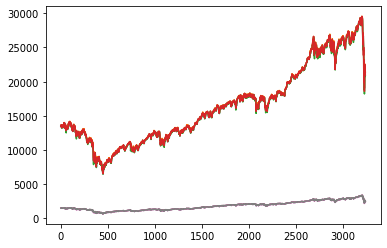

In [11]:
# make data and target arrays
target_style = 'two candles' # / 'one candle' / 'two candles'
window_len = 100 # window length to use for prediction
useVolume = True
useJoined = True # use the joined data
if useJoined:
  data = joined_data
else:
  target_style = 'one candle'
  data = data_DJI

if target_style == 'one candle':
  y = np.zeros((data.shape[0]-window_len,4))
else:
  y = np.zeros((data.shape[0]-window_len,8))

if useJoined:
  if useVolume:
    X = np.zeros((data.shape[0]-window_len,window_len,data.shape[1]-1))
  else:
    X = np.zeros((data.shape[0]-window_len,window_len,data.shape[1]-3))
else:
  if useVolume:
    X = np.zeros((data.shape[0]-window_len,window_len,data.shape[1]-1))
  else:
    X = np.zeros((data.shape[0]-window_len,window_len,data.shape[1]-2))



for i in range(data.shape[0]-window_len):
  if target_style == 'one candle':
    # predict next candle
    y[i] = data.iloc[i+window_len,1:5]
  else:
    # predict next candle in both datas
    y[i][:4] = data.iloc[i+window_len,1:5]
    y[i][4:] = data.iloc[i+window_len,6:10]
        
  if useVolume:
    X[i,:,:] = data.iloc[i:i+window_len,1:].values
  else:
    if useJoined:
      X[i,:,:4] = data.iloc[i:i+window_len,1:5].values
      X[i,:,4:] = data.iloc[i:i+window_len,6:10].values
    else:
      X[i,:,:] = data.iloc[i:i+window_len,1:-1].values
    

plt.plot(y)
plt.show()

In [12]:
X[-1,-10:,:]
y[-1]

array([21285.929688, 21447.810547, 20863.089844, 21052.529297,
        2514.919922,  2538.179932,  2459.959961,  2488.649902])

In [0]:
# train test split
y_train = y[:int(0.7*len(y)),:]
y_valid = y[int(0.7*len(y)):int(0.85*len(y)),:]
y_test = y[int(0.85*len(y)):,:]
X_train = X[:int(0.7*len(X)),:,:]
X_valid = X[int(0.7*len(X)):int(0.85*len(X)),:,:]
X_test = X[int(0.85*len(X)):,:,:]

In [14]:
# get the max and min in the train data
if useJoined:
  if useVolume:
    maxPrice = np.max(X_train[:,:,:4])
    print('max Price: ',maxPrice)
    minPrice = np.min(X_train[:,:,:4])
    print('min Price: ',minPrice)
    maxPrice2 = np.max(X_train[:,:,5:-1])
    print('max Price2: ',maxPrice2)
    minPrice2 = np.min(X_train[:,:,5:-1])
    print('min Price2: ',minPrice2)
    maxVolume = np.max(X_train[:,:,4])
    print('max Volume: ',maxVolume)
    minVolume = np.min(X_train[:,:,4])
    print('min Volume: ',minVolume)
    maxVolume2 = np.max(X_train[:,:,-1])
    print('max Volume2: ',maxVolume2)
    minVolume2 = np.min(X_train[:,:,-1])
    print('min Volume2: ',minVolume2)
  else:
    maxPrice = np.max(X_train[:,:,:4])
    print('max Price: ',maxPrice)
    minPrice = np.min(X_train[:,:,:4])
    print('min Price: ',minPrice)
    maxPrice2 = np.max(X_train[:,:,4:])
    print('max Price: ',maxPrice)
    minPrice2 = np.min(X_train[:,:,4:])
    print('min Price: ',minPrice)
else:
  maxPrice = np.max(X_train[:,:,:-1])
  print('max Price: ',maxPrice)
  minPrice = np.min(X_train[:,:,:-1])
  print('min Price: ',minPrice)
  if useVolume:
    maxVolume = np.max(X_train[:,:,-1])
    print('max Volume: ',maxVolume)
    minVolume = np.min(X_train[:,:,-1])
    print('min Volume: ',minVolume)




max Price:  18351.359375
min Price:  6469.950195
max Price2:  2134.719971
min Price2:  666.789978
max Volume:  674920000.0
min Volume:  8410000.0
max Volume2:  11456230000.0
min Volume2:  1025000000.0


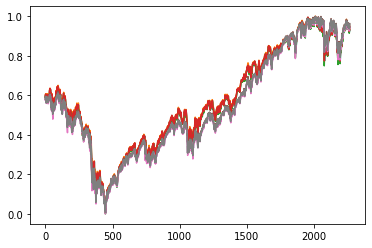

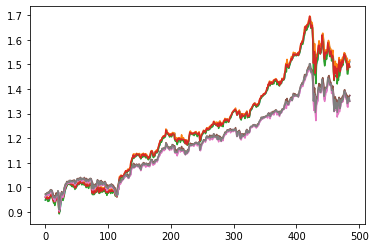

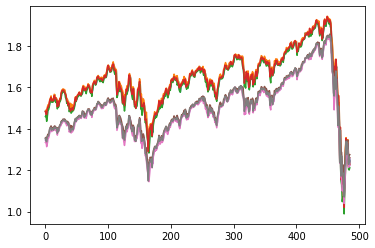

In [15]:
# data scaling
if useJoined:
  if useVolume:
    X_train[:,:,:4] = (X_train[:,:,:4] - minPrice) / (maxPrice - minPrice)
    X_train[:,:,4] = (X_train[:,:,4] - minVolume) / (maxVolume - minVolume)
    X_train[:,:,5:-1] = (X_train[:,:,5:-1] - minPrice2) / (maxPrice - minPrice2)
    X_train[:,:,-1] = (X_train[:,:,-1] - minVolume2) / (maxVolume2 - minVolume2)

    X_valid[:,:,:4] = (X_valid[:,:,:4] - minPrice) / (maxPrice - minPrice)
    X_valid[:,:,4] = (X_valid[:,:,4] - minVolume) / (maxVolume - minVolume)
    X_valid[:,:,5:-1] = (X_valid[:,:,5:-1] - minPrice2) / (maxPrice2 - minPrice2)
    X_valid[:,:,-1] = (X_valid[:,:,-1] - minVolume2) / (maxVolume2 - minVolume2)

    X_test[:,:,:4] = (X_test[:,:,:4] - minPrice) / (maxPrice - minPrice)
    X_test[:,:,4] = (X_test[:,:,4] - minVolume) / (maxVolume - minVolume)
    X_test[:,:,5:-1] = (X_test[:,:,5:-1] - minPrice2) / (maxPrice2 - minPrice2)
    X_test[:,:,-1] = (X_test[:,:,-1] - minVolume2) / (maxVolume2 - minVolume2)
  else:
    X_train[:,:,:4] = (X_train[:,:,:4] - minPrice) / (maxPrice - minPrice)
    X_train[:,:,4:] = (X_train[:,:,4:] - minPrice2) / (maxPrice - minPrice2)

    X_valid[:,:,:4] = (X_valid[:,:,:4] - minPrice) / (maxPrice - minPrice)
    X_valid[:,:,4:] = (X_valid[:,:,4:] - minPrice2) / (maxPrice2 - minPrice2)

    X_test[:,:,:4] = (X_test[:,:,:4] - minPrice) / (maxPrice - minPrice)
    X_test[:,:,4:] = (X_test[:,:,4:] - minPrice2) / (maxPrice2 - minPrice2)
else:
  if useVolume:
    X_train[:,:,:-1] = (X_train[:,:,:-1] - minPrice) / (maxPrice - minPrice)
    X_train[:,:,-1] = (X_train[:,:,-1] - minVolume) / (maxVolume - minVolume)

    X_valid[:,:,:-1] = (X_valid[:,:,:-1] - minPrice) / (maxPrice - minPrice)
    X_valid[:,:,-1] = (X_valid[:,:,-1] - minVolume) / (maxVolume - minVolume)

    X_test[:,:,:-1] = (X_test[:,:,:-1] - minPrice) / (maxPrice - minPrice)
    X_test[:,:,-1] = (X_test[:,:,-1] - minVolume) / (maxVolume - minVolume)
  else:
    X_train[:,:,:] = (X_train[:,:,:] - minPrice) / (maxPrice - minPrice)

    X_valid[:,:,:] = (X_valid[:,:,:] - minPrice) / (maxPrice - minPrice)

    X_test[:,:,:] = (X_test[:,:,:] - minPrice) / (maxPrice - minPrice)



# target scaling
if target_style == 'one candle':
    y_train = (y_train - minPrice) / (maxPrice - minPrice)
    plt.plot(y_train)
    plt.show()
    y_valid = (y_valid - minPrice) / (maxPrice - minPrice)
    plt.plot(y_valid)
    plt.show()
    y_test = (y_test - minPrice) / (maxPrice - minPrice)
    plt.plot(y_test)
    plt.show()
if target_style == 'two candles':
    y_train[:,:4] = (y_train[:,:4] - minPrice) / (maxPrice - minPrice)
    y_train[:,4:] = (y_train[:,4:] - minPrice2) / (maxPrice2 - minPrice2)
    plt.plot(y_train)
    plt.show()
    y_valid[:,:4] = (y_valid[:,:4] - minPrice) / (maxPrice - minPrice)
    y_valid[:,4:] = (y_valid[:,4:] - minPrice2) / (maxPrice2 - minPrice2)
    plt.plot(y_valid)
    plt.show()
    y_test[:,:4] = (y_test[:,:4] - minPrice) / (maxPrice - minPrice)
    y_test[:,4:] = (y_test[:,4:] - minPrice2) / (maxPrice2 - minPrice2)
    plt.plot(y_test)
    plt.show()



In [0]:

# from keras.models import Sequential
# import keras.layers as layers
# from keras.layers import Input, Dense, Dropout, LSTM, CuDNNLSTM, GRU, CuDNNGRU, Bidirectional
# from keras.optimizers import SGD, RMSprop, Adam, Adagrad
# from keras.losses import mean_squared_error
# from keras.models import load_model
# from keras import backend as K
# from keras.callbacks import EarlyStopping


In [0]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [0]:

# The GRU architecture
regressorGRU = tf.keras.Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(layers.Dropout(0.2))
# Second GRU layer
regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(layers.Dropout(0.2))
# Third GRU layer
regressorGRU.add(layers.GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorGRU.add(layers.Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(layers.GRU(units=50))
regressorGRU.add(layers.Dropout(0.2))
# The output layer
regressorGRU.add(layers.Dense(units=y_train.shape[1]))


In [0]:

# The LSTM architecture
regressorLSTM = tf.keras.Sequential()
# First LSTM layer with Dropout regularisation
regressorLSTM.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressorLSTM.add(layers.Dropout(0.2))
# Second LSTM layer
regressorLSTM.add(layers.LSTM(units=50, return_sequences=True))
regressorLSTM.add(layers.Dropout(0.2))
# Third LSTM layer
regressorLSTM.add(layers.LSTM(units=50, return_sequences=True))
regressorLSTM.add(layers.Dropout(0.2))
# Fourth LSTM layer 
regressorLSTM.add(layers.LSTM(units=50))
regressorLSTM.add(layers.Dropout(0.2))
# The output layer
regressorLSTM.add(layers.Dense(units=y_train.shape[1]))


In [0]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    SS_reg = K.sum(K.square(y_pred - K.mean(y_true)))
#     return ( 1 - SS_res/(SS_tot + K.epsilon()) )
    return ( SS_res/(SS_tot + K.epsilon()) )
#     return ( SS_reg/(SS_tot + K.epsilon()) )

In [20]:
# regressor = regressorLSTM
regressor = regressorGRU
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
regressor.compile(optimizer='RMSProp', loss='mse', metrics=['mse']) # optimizer='Adam'/'RMSProp' ,r2_score
print(regressor.summary())
hist = regressor.fit(X_train, y_train,epochs = 100, callbacks=[callback], validation_data=(X_valid, y_valid)) # , batch_size=32

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 100, 50)           9300      
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 50)           15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                1

In [21]:
hist.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

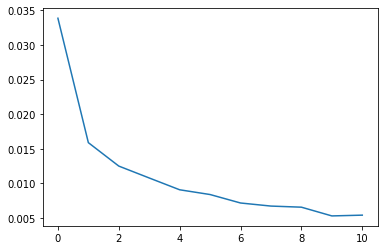

In [22]:
plt.plot(hist.history['loss'])
plt.show()

In [31]:
# predict for lest point
if useJoined:
  if useVolume:
    lest_data = data.iloc[-window_len:,1:].values
  
    lest_data[:,:4] = (lest_data[:,:4] - minPrice) / (maxPrice - minPrice)
    lest_data[:,4] = (lest_data[:,4] - minVolume) / (maxVolume - minVolume)
    lest_data[:,5:-1] = (lest_data[:,5:-1] - minPrice2) / (maxPrice2 - minPrice2)
    lest_data[:,-1] = (lest_data[:,-1] - minVolume2) / (maxVolume2 - minVolume2)
  else:
    lest_data[:,:4] = data.iloc[-window_len:,1:5].values
    lest_data[:,6:10] = data.iloc[-window_len:,6:10].values
    
    lest_data[:,:4] = (lest_data[:,:4] - minPrice) / (maxPrice - minPrice)
    lest_data[:,6:10] = (lest_data[:,6:10] - minPrice2) / (maxPrice2 - minPrice2)
else:
  if useVolume:
    lest_data = data.iloc[-window_len:].values
    
    lest_data[:,:-1] = (lest_data[:,:-1] - minPrice) / (maxPrice - minPrice)
    lest_data[:,-1] = (lest_data[:,-1] - minVolume) / (maxVolume - minVolume)
  else:
    lest_data = data.iloc[-window_len:,:-1].values
    lest_data = (lest_data - minPrice) / (maxPrice - minPrice)
lest_data = lest_data.reshape((1,window_len,X_train.shape[2]))

predicted_stock_price = regressor.predict(lest_data)
# target_style = 'two candles' # / 'one candle' / 'two candles'
if target_style == 'one candle':
  predicted_stock_price = predicted_stock_price * (maxPrice - minPrice) + minPrice
  print("predicted stock price for next step is:")
  print("Open, ", predicted_stock_price[:,0])
  print("High, ", predicted_stock_price[:,1])
  print("Low, ", predicted_stock_price[:,2])
  print("Close, ", predicted_stock_price[:,3])
elif target_style == 'two candles':
  predicted_stock_price1 = predicted_stock_price[:,:4] * (maxPrice - minPrice) + minPrice
  print("predicted first stock price for next step is:")
  print("Open, ", predicted_stock_price1[:,0])
  print("High, ", predicted_stock_price1[:,1])
  print("Low, ", predicted_stock_price1[:,2])
  print("Close, ", predicted_stock_price1[:,3])
  predicted_stock_price2 = predicted_stock_price[:,4:] * (maxPrice2 - minPrice2) + minPrice2
  print("predicted second stock price for next step is:")
  print("Open, ", predicted_stock_price2[:,0])
  print("High, ", predicted_stock_price2[:,1])
  print("Low, ", predicted_stock_price2[:,2])
  print("Close, ", predicted_stock_price2[:,3])



predicted first stock price for next step is:
Open,  [20088.785]
High,  [20187.941]
Low,  [19857.45]
Close,  [20050.781]
predicted second stock price for next step is:
Open,  [2335.446]
High,  [2442.442]
Low,  [2273.5007]
Close,  [2301.8289]


In [0]:
predicted_stock_price = regressor.predict(X_test)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

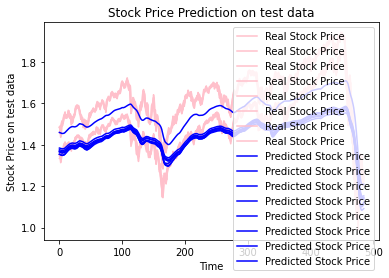

In [25]:
# Visualising the test results
plt.plot(y_test, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on test data')
plt.xlabel('Time')
plt.ylabel('Stock Price on test data')
plt.legend()
plt.show()

In [0]:
predicted_stock_price = regressor.predict(X_valid)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

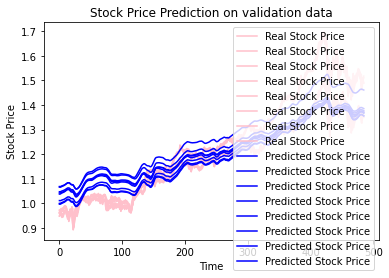

In [27]:
# Visualising the validation results
plt.plot(y_valid, color = 'pink', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on validation data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [28]:
# r2_score(y_valid, predicted_stock_price)
SS_res = np.sum(np.square(y_valid - predicted_stock_price))
print('SS_res = ',SS_res)
SS_tot = np.sum(np.square(y_valid - np.mean(y_valid)))
print('SS_tot = ',SS_tot)
SS_reg = np.sum(np.square(predicted_stock_price - np.mean(y_valid)))
print('SS_reg = ',SS_reg)
r2 = 1 - SS_res/SS_tot
print('r2 = ',r2)
r2 = SS_reg/SS_tot
print('r2 = ',r2)
mse = np.mean(np.square(y_valid - predicted_stock_price))
print('mse = ',mse)

SS_res =  24.947417902631628
SS_tot =  125.6725036314815
SS_reg =  58.727264
r2 =  0.8014886535897563
r2 =  0.4673040061054807
mse =  0.006416516950265337


In [0]:
predicted_stock_price = regressor.predict(X_train)
# if target_style == 'Price':
#     predicted_stock_price = (predicted_stock_price * (maxPrice - minPrice)) + minPrice
# predicted_stock_price

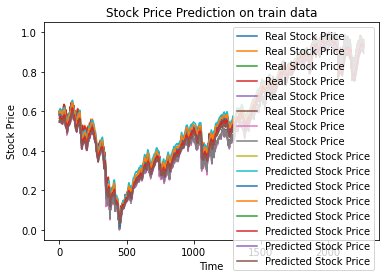

In [30]:
# Visualising the train results
plt.plot(y_train, label = 'Real Stock Price')
plt.plot(predicted_stock_price, label = 'Predicted Stock Price')
plt.title('Stock Price Prediction on train data')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close('all')